<a href="https://colab.research.google.com/github/pescoto0325/Pablo_Portfolio/blob/main/Pablo_Escoto_A12_Predictive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Rationale** In this exercise, you will get some hands on experience at building a product recommender system using collaborative filtering. In particular, we will implement Singular Value Decomposition.

In this script, we will build a venue (mostly restaurant) recommender system based on users' Yelp reviews.

**Note this dataset is slightly different compared to previous Yelp data**\
[Dataset](https://drive.google.com/drive/folders/1AqwmO8XJhn_i9AnZfcfu-sgzN96V7zVS?usp=sharing): Use review data for the heavy lifting, business data supplements (merge in when needed). 

# 1. Pre-processing

1. Read in the Quebec Yelp Reviews Dataset + business datasets as df and df_biz, respectively. Specify the index_col = 0 option when reading in.  Be sure to reset and drop the index after reading in.
1. Find all users who have written **50** or more reviews. Call this list `uids`
    1. Review data visualization assignment for hint (where you selected only popular categories for Rent the Runway).
1. Find all businesses that have received **25** or more reviews. Call this list `bids`
1. Filter the reviews data to only include reviews written by users belong to `uids` and for the businesses belong to `bids`.
1. Drop duplicates on `user_id` and `business_id` so that you only have 1 review for 1 business for each user.

In [34]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics import pairwise_distances

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
! pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached hdbscan-0.8.28.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2340216 sha256=c11126a8beed990e8b1864e6d4cee74c53203278db746ec1cf556f65b59ac54a
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [37]:
dfp = pd.read_csv("/content/drive/MyDrive/Copy of quebec_yelp_reviews.csv", index_col = 0,engine='python',skip_blank_lines=True)
df_biz = pd.read_csv("/content/drive/MyDrive/Copy of quebec_biz.csv",skip_blank_lines=True)


In [38]:
dfp.head(2)
dfp.shape

(208166, 22)

In [39]:
df_biz.shape

(10233, 15)

In [40]:
df = dfp.dropna()
df_biz = df_biz.dropna()

In [41]:
df.head(2)
df.shape

(181725, 22)

In [42]:
df_biz.shape

(6952, 15)

In [43]:
df.head(2)
df.shape

(181725, 22)

In [44]:
business = df[['business_id','user_id','stars']]

In [45]:
mratings = df[['business_id','user_id','stars','date']]

mratings.drop_duplicates(['user_id', 'business_id'],inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [46]:
nl = df.groupby('user_id')['business_id','review_id','stars'].count().reset_index()
stemp = nl.sort_values(by='review_id',ascending=False)
new = nl[nl['review_id'] > 49]
uids = new['user_id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [47]:
nl2 = df.groupby('business_id')['user_id','review_id','stars'].count().reset_index()
stemp2 = nl2.sort_values(by='review_id',ascending=False)
new2 = nl2[nl2['review_id'] > 24]
bids = new2['business_id']
bids

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


1       -1xuC540Nycht_iWFeJ-dw
2       -3Haoc0l9DZRSXxIHi9oJg
9       -8hAGEWRSKtpLZ8e3L2xhA
10      -92cC6-X87HQ1DE1UHOx3w
21      -HsqnPAz374YSoyFDyjl3A
                 ...          
6931    zrnP9HqoF-RI9jqoW8pytA
6932    zsMMlOYtXm8SNy0bl1leBA
6940    zw4Legbcu018p5WcZ74iWA
6943    zwkif4XLEDqdEwEgTWLIVQ
6951    zzlZJVkEhOzR2tJOLHcF2A
Name: business_id, Length: 1690, dtype: object

In [48]:
df2 = df.copy()
df3 = df2[df2['user_id'].isin(uids)] 
df4 = df3[df3['business_id'].isin(bids)]

In [49]:
df6 = df4.drop_duplicates(subset=['user_id','business_id'])

In [50]:
df6.shape


(22627, 22)

In [51]:
df6 = df6.sample(frac=0.5)
#Using 50% of the data to prevent them from crashing

In [52]:
df6.shape

(11314, 22)

In [53]:
dfsample = df6.sample(frac=0.1)

df6.columns()

# 2. SVD based Collaborative Filtering

Run a k-fold cross validated latent factor selection on the SVD based collaborative filtering.

1. Run a cross-validated latent factor search for 1-20 factors with each iteration having 10-folds. Refer to notes for module.
1. Produce the latent dimension vs. MSE plot. How many latent factors appear to yield the best out of sample prediction fit?


In [54]:
dfpivot = df6.pivot(index='user_id',columns='business_id',values='stars')
dfpivot.head(2)

business_id,-1xuC540Nycht_iWFeJ-dw,-3Haoc0l9DZRSXxIHi9oJg,-8hAGEWRSKtpLZ8e3L2xhA,-92cC6-X87HQ1DE1UHOx3w,-HsqnPAz374YSoyFDyjl3A,-Levln3VcfeXS4iHt5ct9A,-MwaICRwxaUi0JBfad2Y3Q,-Mz3M0g6iFZczs6a7ddf5g,-NIpCMONu69292q9Itiipg,-OhQws_Si3YOYDfm6DilxA,...,zWVSNGmW2O1iN7PEViyK5A,zktCQRlDtF6XmOpqKBz1mA,zmQyE-gIUpwBCMmTFFRbJw,zpw5S3QwUse1MH-Eerbnaw,zr2wA55AskfBJxrvUeDZRA,zrnP9HqoF-RI9jqoW8pytA,zsMMlOYtXm8SNy0bl1leBA,zw4Legbcu018p5WcZ74iWA,zwkif4XLEDqdEwEgTWLIVQ,zzlZJVkEhOzR2tJOLHcF2A
user_id,,,,,,,,,,,,,,,,,,,,,
-5ohKzWWOzAG1M1OtcoPgQ,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-8nmj3B-tfY_vFiimtBOsw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
user_means = dfpivot.mean(axis = 1)
user_means

user_id
-5ohKzWWOzAG1M1OtcoPgQ    3.555556
-8nmj3B-tfY_vFiimtBOsw    3.714286
-9b4s874f_CnznTu4JorRg    4.037037
-KpEgEen1tj-jdjIS7uVOw    3.823529
-NwDw6HgVpA4ys6WYcI6Xg    4.090909
                            ...   
ygjIo5gLQ8wmsOcTDiHG2Q    3.894737
yphnJ8zYbJF7Y3QbtMj91g    3.986111
zIOxNinC6ofIwwGjO9rUWg    3.710526
zyg4-MFtfPWmwucVazSjfw    3.526316
zzKsgIF472IyDpJxmHDIpw    3.333333
Length: 339, dtype: float64

In [56]:
dfpivot = dfpivot.sub(user_means, axis = 0)
#dfpivot.fillna(0, inplace = True)
dfpivot.head(2)

business_id,-1xuC540Nycht_iWFeJ-dw,-3Haoc0l9DZRSXxIHi9oJg,-8hAGEWRSKtpLZ8e3L2xhA,-92cC6-X87HQ1DE1UHOx3w,-HsqnPAz374YSoyFDyjl3A,-Levln3VcfeXS4iHt5ct9A,-MwaICRwxaUi0JBfad2Y3Q,-Mz3M0g6iFZczs6a7ddf5g,-NIpCMONu69292q9Itiipg,-OhQws_Si3YOYDfm6DilxA,...,zWVSNGmW2O1iN7PEViyK5A,zktCQRlDtF6XmOpqKBz1mA,zmQyE-gIUpwBCMmTFFRbJw,zpw5S3QwUse1MH-Eerbnaw,zr2wA55AskfBJxrvUeDZRA,zrnP9HqoF-RI9jqoW8pytA,zsMMlOYtXm8SNy0bl1leBA,zw4Legbcu018p5WcZ74iWA,zwkif4XLEDqdEwEgTWLIVQ,zzlZJVkEhOzR2tJOLHcF2A
user_id,,,,,,,,,,,,,,,,,,,,,
-5ohKzWWOzAG1M1OtcoPgQ,NaN,NaN,NaN,NaN,0.444444,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-8nmj3B-tfY_vFiimtBOsw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **DOING THE SVD**


In [57]:
from scipy.sparse.linalg import svds # import singular value decomposition
l = 2 # run for 2 latent features (usually we'll have more than 2 features, 2D is easier to visualize)
U, sigma, Vt = svds(dfpivot, k = l) 
# u is the user preferences over latent features
# sigma is the weighting of the latent features
# Vt is the item's representation on the latent dimensions

In [58]:
U.shape, sigma.shape, Vt.shape, dfpivot.shape

((339, 2), (2,), (2, 1627), (339, 1627))

### Before we make predictions, let's explore these **decompositions**

In [59]:
usertastes = pd.DataFrame(U, columns = ['l1', 'l2'])
usertastes['user_Id'] = dfpivot.index.values
usertastes.head()

,l1,l2,user_Id
0,0.053032,0.024514,-5ohKzWWOzAG1M1OtcoPgQ
1,0.010918,0.022530,-8nmj3B-tfY_vFiimtBOsw
2,-0.028076,0.045040,-9b4s874f_CnznTu4JorRg
3,0.002127,0.025536,-KpEgEen1tj-jdjIS7uVOw
4,-0.001075,0.017686,-NwDw6HgVpA4ys6WYcI6Xg


In [60]:
itemvalues = pd.DataFrame(Vt.T, columns = ['l1', 'l2']) # flip it back to vertical using .T (transpose)
itemvalues['business_id'] = dfpivot.columns.values
itemvalues = itemvalues.merge(df6, how = 'left', on = 'business_id')
itemvalues.head()

,l1,l2,business_id,review_id,user_id,stars,useful,funny,cool,text,...,state,postal_code,latitude,longitude,stars_biz,review_count,is_open,attributes,categories,hours
0,-0.036762,-0.029165,-1xuC540Nycht_iWFeJ-dw,sCflJHBjGulDeH48ok32ZA,aYL7qtwOMdzYayaddq_Hnw,4,1,0,0,Pretty much the best Portuguese chicken on the...,...,QC,H2W 1C8,45.51931,-73.580749,4.0,497,1,"{'GoodForKids': 'True', 'RestaurantsDelivery':...","Restaurants, Portuguese, Bakeries, Barbeque, C...","{'Monday': '6:30-21:0', 'Tuesday': '6:30-21:0'..."
1,-0.036762,-0.029165,-1xuC540Nycht_iWFeJ-dw,8GhL5t3KOS_cZ2aO6ykOnw,FdMNvBDX--D_MWuu5qKWDw,5,1,0,0,"Romados c'est ma place!!! Le poulet, les frite...",...,QC,H2W 1C8,45.51931,-73.580749,4.0,497,1,"{'GoodForKids': 'True', 'RestaurantsDelivery':...","Restaurants, Portuguese, Bakeries, Barbeque, C...","{'Monday': '6:30-21:0', 'Tuesday': '6:30-21:0'..."
2,-0.036762,-0.029165,-1xuC540Nycht_iWFeJ-dw,gsciCxAMUBruKgdA43KvgQ,VXbi8ndacawnd6kidQF8dw,4,1,0,1,So I have nothing to say against the food. The...,...,QC,H2W 1C8,45.51931,-73.580749,4.0,497,1,"{'GoodForKids': 'True', 'RestaurantsDelivery':...","Restaurants, Portuguese, Bakeries, Barbeque, C...","{'Monday': '6:30-21:0', 'Tuesday': '6:30-21:0'..."
3,-0.036762,-0.029165,-1xuC540Nycht_iWFeJ-dw,BVhOpA1iUbOJorvGPK1-_A,_xgxMsX2f99Cgzy009Y_lg,5,0,0,0,Sometimes I get a major craving for this chick...,...,QC,H2W 1C8,45.51931,-73.580749,4.0,497,1,"{'GoodForKids': 'True', 'RestaurantsDelivery':...","Restaurants, Portuguese, Bakeries, Barbeque, C...","{'Monday': '6:30-21:0', 'Tuesday': '6:30-21:0'..."
4,-0.036762,-0.029165,-1xuC540Nycht_iWFeJ-dw,DVDfKWHg58t-mOdatUbg_w,1ViT_LzrNbbrheWgIvT5Tw,5,5,0,5,"Atmosphere, Service, Food: What you need to kn...",...,QC,H2W 1C8,45.51931,-73.580749,4.0,497,1,"{'GoodForKids': 'True', 'RestaurantsDelivery':...","Restaurants, Portuguese, Bakeries, Barbeque, C...","{'Monday': '6:30-21:0', 'Tuesday': '6:30-21:0'..."


Text(0, 0.5, 'l2')

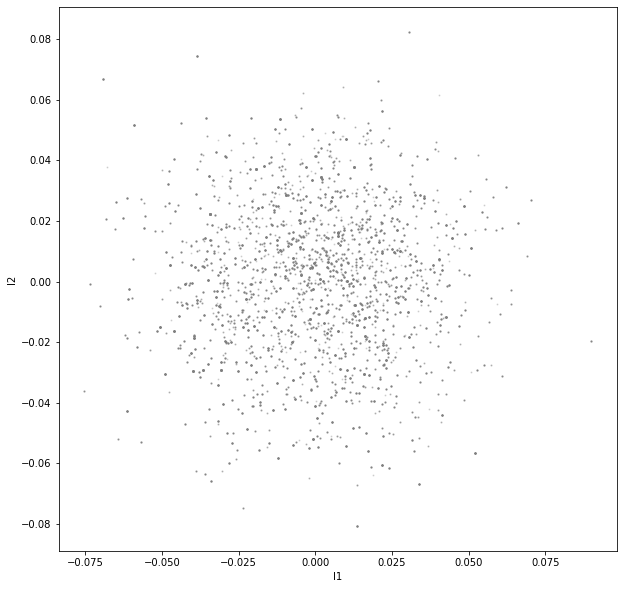

In [61]:
fig, ax = plt.subplots(1, figsize = (10,10))
ax.scatter(itemvalues.l1, itemvalues.l2, s= 1, color = 'gray', alpha = .25)
ax.set_xlabel('l1')
ax.set_ylabel('l2')

### Identifying Business segmens

In [62]:
import hdbscan 
clusterer = hdbscan.HDBSCAN(min_cluster_size = 10)

In [63]:
itemvalues['cluster'] = clusterer.fit_predict(itemvalues[['l1', 'l2']])

In [64]:
clusters = sorted(itemvalues.cluster.unique())
len(clusters)-1 # number of clusters excluding unclassifiable

476

In [65]:
def predict_ratings(U, sigma, Vt, means):
    """
    Take in the U, sigma, Vt, and means ratings matrices
    Compute dot product U * Sigma * Vt add on means + means
    Returns rating predictions
    """
    predicted_ratings = U @ np.diag(sigma) @ Vt + np.array(means).reshape(-1,1)
    return predicted_ratings


In [66]:
def get_ratings(predictions,user, exclude = [], top = 5):
    cols = [c for c in predictions.columns if c not in exclude]
    preds = predictions.loc[user,cols].T.sort_values(ascending = False)
    return preds.iloc[:top]

### Factor Search with 10 folds

In [67]:
from sklearn.model_selection import train_test_split
mratings_train, mratings_test = train_test_split(mratings, test_size=0.1)

In [68]:
np.random.seed(1)
folds = 10 # let's do 10 folds
mratings['fold'] = np.random.randint(0,folds, len(mratings))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
mratings_train.shape, mratings_test.shape

((160470, 4), (17830, 4))

In [70]:
uids = set(mratings_test.user_id.unique())-set(mratings_train.user_id.unique())
print(uids)
# if there are, put back into training data:
temp = mratings_test[mratings_test.user_id.isin(uids)]
mratings_train = pd.concat([mratings_train, temp]) # concatenate with train
mratings_test = mratings_test[~mratings_test.user_id.isin(uids)] # get rid of those rows from test

{'cYedbaqGKzso4GXwuaCrag', 'dunuI1ld7oAE8n_cxqR_TQ', 'aZy39dfDIOQ_cnPWjhrurA', 'uOCeUWDvxDt1g_6aX3MMbQ', 'iyEWBKYfSByp3QxMyOE3dA', 'd-aM_z394lpTfu_PaVQ_PQ', 'MgP72Df7OE0TXOEqbixhdA', 'y6PzEaEEg71tsalIEoz02w', 'cxyiCHgsmoX2ChdbHU7ZJg', 'P22krqkR5VwZtUgFOWpFxA', 'eCm1PJ58PxcXapQKd7mjVQ', 'zwPecMicGkmkyErCTxheHg', 'p_8G3mrojESNVJ4E-zvGKQ', 'LnBj1xFRGIoRqSf5TCJfXw', 'L3CGTEYqAURIjv9zJV7URQ', 'rKK4tvsHZl55h4PkzdkOkw', 'nnoWwWU3QIM8FKhToPg5Gg', '_8AZXcylhU46MVgO5iOy5Q', 'pq4DFJGmf8ZvWCTwMpNlWA', 'qRgLUxTCwjogycdM12sxyg', '6jhGZrYiyxUTROWiexXIjw', 'HJQDV4iOMTc2Wj3_Xg4XDw', 'skKfFXUcMLT_E2ZlpdKdVA', '5GZAIMObFT8gEzcnwGNg5Q', 'nFpdgljK6TEMSXtLx-z4-w', 'Q22WcxNg6CEoj8cY3yYSlA', 'r27h3GiZvQ7MVmDQt6lbJg', 'ArLF_qvg9F67kmmRmN3WXg', 'PrBrStKVl9qRhZdg9cN8dQ', 'Fz114x8pyM8gXW5pDitMOg', '_QPAdhyE9yskJQS6YOjQKg', '0I1dVZpjNfcTuhHNhCHUHw', 'Dj4lWAE9sv-h-M5jNlgynA', 'lsSdB-zLKFvLPzWFNP9yUw', '2IHLjdwu6184ZWlqjSE76w', 'Xlr7jRxSmzilPZbh9qBO3Q', 'OQ3mo20kpFk578QsSyi2UQ', 'x0txHhXNp99eaPjxtwGeZg', 'c8CJx1k0xQ

In [71]:
mids = set(mratings_test.business_id.unique())-set(mratings_train.business_id.unique())
print(mids)
# if there are, put back into train:
temp = mratings_test[mratings_test.business_id.isin(mids)]
mratings_train = pd.concat([mratings_train, temp]) # concatenate with train
mratings_test = mratings_test[~mratings_test.business_id.isin(mids)] # get rid of those rows from test

set()


In [72]:
# final shape
mratings_train.shape, mratings_test.shape

((163963, 4), (14337, 4))

In [73]:
mratings_canonical = mratings_train.pivot(index = 'user_id', columns = 'business_id', values = 'stars')

In [74]:
# compute user demeaned ratings matrix
user_means = mratings_canonical.mean(axis = 1) # create user means, store here, need later 

mratings_canonical = mratings_canonical.sub(user_means, axis = 0)
# fill in missing values

mratings_canonical.fillna(0, inplace = True)
# preview dataset
mratings_canonical.head()

business_id,-1CI4H3DLkI-NdWLbIae6g,-1xuC540Nycht_iWFeJ-dw,-3Haoc0l9DZRSXxIHi9oJg,-4lgvwr6d8ztCPlCXl-NFA,-4mowOKV3xGyfgQBh6ey_g,-5IV_IrH5D7hyip2P_w7BA,-7YM8-nptYNTirnR_nCcPg,-7bRnaHp7OHz8KW-THqP4w,-8AoSGOdZyDdTpT2oqX3zQ,-8hAGEWRSKtpLZ8e3L2xhA,...,zwgVuZcMgijt9k3Jq-2zQQ,zwkif4XLEDqdEwEgTWLIVQ,zxxemSe137HGuaplXhd23w,zySx88a8wu-mpPIkg5ijcQ,zyfPzBC4s17UWh6x8olj7w,zyhr9tExYX8myjpJY0F_2Q,zza5aje9ElBdWOO3Qtfk_Q,zzdJkVrJ8OkZPUxrvLMkYQ,zzjKekzQ6i4iR-qpo405Pw,zzlZJVkEhOzR2tJOLHcF2A
user_id,,,,,,,,,,,,,,,,,,,,,
--2PnhMMH7EYoY3wywOvgQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--6kLBBsm0GPM9vIB2YBDw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--8NUFYnpU_Zu09TgcLevw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--AVaBo8pJHut43HjdWuOA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--B08Ekk4Y_4KFuF9MWdtw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
l = 50 # run for larger latent dimensions
U, sigma, Vt = svds(mratings_canonical, k = l) 

In [76]:
# Make prediction
predicted_ratings = predict_ratings(U, sigma, Vt, user_means)
predicted_ratings = pd.DataFrame(predicted_ratings, columns = mratings_canonical.columns)
predicted_ratings.index=mratings_canonical.index

In [ ]:
predicted_ratings_stack = predicted_ratings.stack().reset_index()
predicted_ratings_stack.columns = ['user_id', 'business_id', 'predicted_rating']
predicted_ratings_stack.head()

In [ ]:
mratings_test = mratings_test.merge(predicted_ratings_stack, how = 'left', on = ['business_id', 'user_id'])
mratings_test.head()

In [ ]:
mratings_test[['stars', 'predicted_rating']].corr()

In [ ]:
mratings_test['error'] = mratings_test.predicted_rating-mratings_test.stars
mse = (mratings_test.error @ mratings_test.error)/len(mratings_test) # sum of squares = dot produt of vector with itself
print(mse) # avg squared error

In [ ]:
np.random.seed(1)
folds = 10 # let's do 10 folds
mratings['fold'] = np.random.randint(0,folds, len(mratings)) # randomly assign group 0-9, inclusive, to each observations

In [ ]:
# copy paste from previous work inside of loop
MSE = list()
for l in range(5,51, 5): # from 5 to 50 in increments of 5
    mselist = list()
    for f in list(range(folds)):
        # define train/test split
        mratings_train = mratings[mratings.fold!= f] # training is all other samples
        mratings_test = mratings[mratings.fold == f] # testing is the current fold

        # there should not be uid's in test that are not in train
        uids = set(mratings_test.user_id.unique())-set(mratings_train.user_id.unique())
        # if there are, put back into trai:
        temp = mratings_test[mratings_test.user_id.isin(uids)]
        mratings_train = pd.concat([mratings_train, temp]) # concatenate with train
        mratings_test = mratings_test[~mratings_test.user_id.isin(uids)] # get rid of those rows from test

        # there should not be business ID's in test that are not in train
        mids = set(mratings_test.business_id.unique())-set(mratings_train.business_id.unique())
        # if there are, put back into train:
        temp = mratings_test[mratings_test.business_id.isin(mids)]
        mratings_train = pd.concat([mratings_train, temp]) # concatenate with train
        mratings_test = mratings_test[~mratings_test.business_id.isin(mids)] # get rid of those rows from test

        # make canonical form again
        mratings_canonical = mratings_train.pivot(index = 'user_id', columns = 'business_id', values = 'stars')
        
        # compute user demeaned ratings matrix
        user_means = mratings_canonical.mean(axis = 1) # create user means, store here, need later 
        mratings_canonical = mratings_canonical.sub(user_means, axis = 0)
        
        # fill in missing values
        mratings_canonical.fillna(0, inplace = True)

        # SVD
        U, sigma, Vt = svds(mratings_canonical, k = l) 

        # Make prediction
        predicted_ratings = predict_ratings(U, sigma, Vt, user_means)
        predicted_ratings = pd.DataFrame(predicted_ratings, columns = mratings_canonical.columns)
        predicted_ratings.index=mratings_canonical.index

        # unpivot this prediction (stack) dataframe
        predicted_ratings_stack = predicted_ratings.stack().reset_index()
        predicted_ratings_stack.columns = ['user_id', 'business_id', 'pred_rating']
        
        # merge with test data
        mratings_test = mratings_test.merge(predicted_ratings_stack, how = 'left', on = ['user_id', 'business_id'])

        # compute MSE
        mratings_test['error'] = mratings_test.pred_rating-mratings_test.stars
        mse = (mratings_test.error @ mratings_test.error)/len(mratings_test) # sum of squares = dot produt of vector with itself
        

        # Store MSE
        mselist.append(mse)
    MSE.append([l, np.mean(mselist)]) # append l, mselist to MSE 
    print('l: {}, MSE: {:.4f}'.format(l,np.mean(mselist))) 
MSE = pd.DataFrame(MSE, columns = ['l', 'mse']) # convert to pandas df for easy manipulation

In [ ]:
np.mean(mselist)

In [ ]:
plt.scatter(MSE.l, MSE.mse) # looks like 10 is best

# 3. Evaluate best out of sample fitting CF model

1. Using the optimal number of latent factors. Re-run the SVD algorithm on a train / test split where roughly 10% of the data is used for testing.
    1. What is the out of sample correlation between predicted and actual ratings?




In [ ]:
#These segments do not run because it always crashed my session, please let me know how you fixed it.

dfpivot1 = dfsample.pivot(index='user_id',columns='business_id',values='stars')
user_means1 = dfpivot1.mean(axis = 1)
dfpivot1 = dfpivot1.sub(user_means1, axis = 0)

In [ ]:
# copy paste from previous work inside of loop
MSE = list()
for l in range(5,51, 5): # from 5 to 50 in increments of 5
    mselist = list()
    for f in list(range(folds)):
        # define train/test split
        mratings_train = mratings[mratings.fold!= f] # training is all other samples
        mratings_test = mratings[mratings.fold == f] # testing is the current fold

        # there should not be uid's in test that are not in train
        uids = set(mratings_test.user_id.unique())-set(mratings_train.user_id.unique())
        # if there are, put back into trai:
        temp = mratings_test[mratings_test.user_id.isin(uids)]
        mratings_train = pd.concat([mratings_train, temp]) # concatenate with train
        mratings_test = mratings_test[~mratings_test.user_id.isin(uids)] # get rid of those rows from test

        # there should not be business ID's in test that are not in train
        mids = set(mratings_test.business_id.unique())-set(mratings_train.business_id.unique())
        # if there are, put back into train:
        temp = mratings_test[mratings_test.business_id.isin(mids)]
        mratings_train = pd.concat([mratings_train, temp]) # concatenate with train
        mratings_test = mratings_test[~mratings_test.business_id.isin(mids)] # get rid of those rows from test

        # make canonical form again
        mratings_canonical = mratings_train.pivot(index = 'user_id', columns = 'business_id', values = 'stars')
        
        # compute user demeaned ratings matrix
        user_means = mratings_canonical.mean(axis = 1) # create user means, store here, need later 
        mratings_canonical = mratings_canonical.sub(user_means, axis = 0)
        
        # fill in missing values
        mratings_canonical.fillna(0, inplace = True)

        # SVD
        U, sigma, Vt = svds(mratings_canonical, k = l) 

        # Make prediction
        predicted_ratings = predict_ratings(U, sigma, Vt, user_means)
        predicted_ratings = pd.DataFrame(predicted_ratings, columns = mratings_canonical.columns)
        predicted_ratings.index=mratings_canonical.index

        # unpivot this prediction (stack) dataframe
        predicted_ratings_stack = predicted_ratings.stack().reset_index()
        predicted_ratings_stack.columns = ['user_id', 'business_id', 'pred_rating']
        
        # merge with test data
        mratings_test = mratings_test.merge(predicted_ratings_stack, how = 'left', on = ['user_id', 'business_id'])

        # compute MSE
        mratings_test['error'] = mratings_test.pred_rating-mratings_test.stars
        mse = (mratings_test.error @ mratings_test.error)/len(mratings_test) # sum of squares = dot produt of vector with itself
        

        # Store MSE
        mselist.append(mse)
    MSE.append([l, np.mean(mselist)]) # append l, mselist to MSE 
    print('l: {}, MSE: {:.4f}'.format(l,np.mean(mselist))) 
MSE = pd.DataFrame(MSE, columns = ['l', 'mse']) # convert to pandas df for easy manipulation

In [ ]:
mratings_test[['stars', 'pred_rating']].corr()

2. Run the SVD again, this time on the whole dataset (the dataframe you made after the min review criteria from problem 1 has been applied).


In [ ]:
dfpivot = dfp.pivot(index='user_id',columns='business_id',values='stars')
dfpivot.head(2)
user_means = dfpivot.mean(axis = 1)

In [ ]:
dfpivot = dfpivot.sub(user_means, axis = 0)
#dfpivot.fillna(0, inplace = True)
dfpivot.head(2)

In [ ]:
# copy paste from previous work inside of loop
MSE = list()
for l in range(5,51, 5): # from 5 to 50 in increments of 5
    mselist = list()
    for f in list(range(folds)):
        # define train/test split
        mratings_train = mratings[mratings.fold!= f] # training is all other samples
        mratings_test = mratings[mratings.fold == f] # testing is the current fold

        # there should not be uid's in test that are not in train
        uids = set(mratings_test.user_id.unique())-set(mratings_train.user_id.unique())
        # if there are, put back into trai:
        temp = mratings_test[mratings_test.user_id.isin(uids)]
        mratings_train = pd.concat([mratings_train, temp]) # concatenate with train
        mratings_test = mratings_test[~mratings_test.user_id.isin(uids)] # get rid of those rows from test

        # there should not be business ID's in test that are not in train
        mids = set(mratings_test.business_id.unique())-set(mratings_train.business_id.unique())
        # if there are, put back into train:
        temp = mratings_test[mratings_test.business_id.isin(mids)]
        mratings_train = pd.concat([mratings_train, temp]) # concatenate with train
        mratings_test = mratings_test[~mratings_test.business_id.isin(mids)] # get rid of those rows from test

        # make canonical form again
        mratings_canonical = mratings_train.pivot(index = 'user_id', columns = 'business_id', values = 'stars')
        
        # compute user demeaned ratings matrix
        user_means = mratings_canonical.mean(axis = 1) # create user means, store here, need later 
        mratings_canonical = mratings_canonical.sub(user_means, axis = 0)
        
        # fill in missing values
        mratings_canonical.fillna(0, inplace = True)

        # SVD
        U, sigma, Vt = svds(mratings_canonical, k = l) 

        # Make prediction
        predicted_ratings = predict_ratings(U, sigma, Vt, user_means)
        predicted_ratings = pd.DataFrame(predicted_ratings, columns = mratings_canonical.columns)
        predicted_ratings.index=mratings_canonical.index

        # unpivot this prediction (stack) dataframe
        predicted_ratings_stack = predicted_ratings.stack().reset_index()
        predicted_ratings_stack.columns = ['user_id', 'business_id', 'pred_rating']
        
        # merge with test data
        mratings_test = mratings_test.merge(predicted_ratings_stack, how = 'left', on = ['user_id', 'business_id'])

        # compute MSE
        mratings_test['error'] = mratings_test.pred_rating-mratings_test.stars
        mse = (mratings_test.error @ mratings_test.error)/len(mratings_test) # sum of squares = dot produt of vector with itself
        

        # Store MSE
        mselist.append(mse)
    MSE.append([l, np.mean(mselist)]) # append l, mselist to MSE 
    print('l: {}, MSE: {:.4f}'.format(l,np.mean(mselist))) 
MSE = pd.DataFrame(MSE, columns = ['l', 'mse']) # convert to pandas df for easy manipulation

 3. Pick 2 random **restaurants** and look at the 5 most similar ones to each based on latent factor Cosine similarity. Use the Yelp Biz data or Google/Yelp search to help you figure out some background about the focal and similar businesses. For example, are they similar styles? Similar ratings? Similar location? Similar price range?

In [ ]:
businessdist = pd.DataFrame(pairwise_distances(np.array(itemvalues[['l1', 'l2']]), metric = 'cosine'))
businessdist.index = itemvalues.business_id # replace the indices with business titles (correct order)
businessdist.columns = itemvalues.business_id # replace the columns with business titles (correct order)
businessim = 2-businessdist
businessim = businessim.drop_duplicates()
businessim = businessim.loc[:,~businessim.columns.duplicated()]

We are going to try the first one being "Maison Saunt Paul"

In [ ]:
businesss = '9rT_Zr_A2qYmLaHpSi6eqw'
businessim[business].sort_values(ascending = False).head(6)

The closests in terms of similarity are:


1. E0ZBxYiCbmkTe3W0CxxEbw - Restaurant Santa Lucia
2. 3f0-EXRF0oy6NDsFh9TJKA - GaNaDaRa
3. GXNtumhUuOjCCgcE38LfVA - Sparkles Confections
4. 7_p1nwMwanMbz_u3u8-6gw - Chocolats Favoris
5. 9305Mb-osQjTO3shBj92qg - Angela


They offer different types of cuisine and different types of pricetags. However, They are both in the same area of Montreal Canada

https://www.yelp.com/biz/chocolats-favoris-montr%C3%A9al        
https://www.yelp.com/biz/ganadara-montr%C3%A9al                  
https://www.yelp.com/biz/maison-saint-paul-montr%C3%A9al         
https://www.yelp.ca/biz/sparkles-confections-montr%C3%A9al

We are going to try the second one being "Kem CoBa"

In [ ]:
business2 = '0EnXIr4UQTemA0R2hlyR8g'
businessim[business2].sort_values(ascending = False).head(7)

The closest ones in terms of similarity are: https://www.yelp.com/biz/kem-coba-montr%C3%A9al-2

1. CHK0yz0HKCIvcIxb72bUtQ - Zigzagzoo https://www.yelp.com/biz/zigzagzoo-vaudreuil-dorion
2. 7Ad_P9x3aR09-xjecCuKbw - Le BrÃ»loir
3. t7R-p3dhGV78dSARAFKEOA - Mandy's
4. Vp8Dkam_Hv204Or0hul1NQ - Dev Restaurant http://www.restaurantdev.ca/?lang=fr
5. xDJ8Cfn9AaGODE0hhsXBwQ - Le BiÃ¨rologue

We have the same relationship here, they are all located in Montreal, Canada but they also have a similar pricetag, they all seem to be cheap restaurants

4. Choose a random individual and make 10 predictions for the user. Any intuition linked to their previous rating history? (again consult Yelp/Google/biz dataset for previously reviewed venues' characteristics)

In [ ]:
predicted_ratings = predict_ratings(U, sigma, Vt, user_means)
predicted_ratings = pd.DataFrame(predicted_ratings, columns = dfpivot.columns)
predicted_ratings.index=dfpivot.index

In [ ]:
itemvalues[itemvalues.cluster==3].head(5)

In [ ]:
u = 'qKpkRCPk4ycbllTfFcRbNw' # userId Might change depending on the sample, I always just take the first value out of {itemvalues[itemvalues.cluster==3]}
watched = list(df6.loc[df6.user_id==u, 'business_id'].unique())
print('Already Been to : {}'.format(len(watched)))

In [ ]:
recs = get_ratings(predicted_ratings,u, exclude = watched, top = 10).reset_index()
recs

The 10 predictions are the following:

1. -1xuC540Nycht_iWFeJ-dw - Romados 
2. elj15ZOSk7EvHxy21V_jNw - Invitation V
3. eUA8vJUOcjDpID3fIFZ3fw - Les Menus-Plaisirs
4. eUI230JcFZLajIcDd9SDpQ - Apple Store
5. eXyZTXyayzQKkAQm_vIuXQ - Pho Rachel
6. eZhk_ambeSVX1OOjHDilbQ - B.cycle Spin Studio
7. e_dC3v_kcvn4XtjcOysJxA - Glace des Arts
8. eargTRIm9QK2Og4y3qouYQ - Le PÃ©chÃ© Matinal
9. ecid5p4yhTEJbWEJTuzX3Q - Chef Guru
10. eehnof3F4vRB8ydbRvd_zA - Smart Burger

It appears as the trend keeps trailing into this observation as most of these restaurants kept out in Montreal Canada. However, although some of these places are not restaurants, they are all high quality places and places that are expensive. The Apple store ,Chef Guru and Invitation V being an example.


# Make some conclusions about the performance of this business recommmender built on Yelp reviews. Does it work well? If so, point to evidence of this. If not, what might be holding it back (besides collecting more reviews)?

As we can see from the experiments up top, the recommender does give out the proper results but there is still work to be done. 

We can see how it gives recommendations based on similar business_id but it does not say why is it similar. It does not seem to permit which attributes to look similarly (location, WIFI, Pets, cuisine, rating), it just shows you other businesses with similarities. We can see above how we have the Apple store matched with a Spin Studio.

To improve this, we could make more cleansing into the dataset to see what attributes are most likely to relate with the rating (quality, price, service). Another aspect is what type of business it is. The apple store and a restaurant are completely different so another column that matches the business type would enhance this experience.